In [1]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.transforms import RandAugment

In [2]:
# Angular Error calculation function
def calc_angular_error(pred_vecs, true_vecs):
    # Calculate the dot product between predicted and true vectors
    dot_prod = torch.sum(pred_vecs * true_vecs, dim=1).clamp(-1, 1)
    
    # Calculate the angle in radians between vectors using arccos
    rads = torch.acos(dot_prod)
    
    # Convert to degrees
    degs = rads * 180 / math.pi
    
    # Return mean over the batch
    return degs.mean().item()

# Custom DropPath (Stochastic Depth)
class StochasticDepth(nn.Module):
    def __init__(self, drop_prob=None):
        super(StochasticDepth, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output

# Model Architecture
class TerrainAngleNet(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(TerrainAngleNet, self).__init__()
        # Load DINOv2 ViT-B/14 as backbone
        self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', pretrained=True)

        # Get the total number of blocks in the model
        num_blocks = len(self.feature_extractor.blocks)

        # Freeze patch embedding
        for param in self.feature_extractor.patch_embed.parameters():
            param.requires_grad = False

        # Freeze the first half of transformer blocks
        for i in range(num_blocks // 2):
            for param in self.feature_extractor.blocks[i].parameters():
                param.requires_grad = False

        # Apply stochastic depth to remaining blocks
        try:
            for i in range(num_blocks // 2, num_blocks):
                block = self.feature_extractor.blocks[i]
                # Apply drop path if block has attention
                if hasattr(block, 'attn') and hasattr(block.attn, 'drop_path'):
                    block.attn.drop_path = StochasticDepth(dropout_rate)
                # Apply drop path if block has MLP
                if hasattr(block, 'mlp') and hasattr(block.mlp, 'drop_path'):
                    block.mlp.drop_path = StochasticDepth(dropout_rate)
        except Exception as e:
            print(f"Warning: Could not apply StochasticDepth to DINOv2 blocks: {e}")
            print("Continuing without StochasticDepth. Will rely on dropout in the prediction head.")

        # Get the dimension of the backbone output
        backbone_dim = self.feature_extractor.norm.weight.shape[0]

        # Prediction head
        self.head = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(backbone_dim, backbone_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(backbone_dim // 2, 2)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        angle_vector = self.head(features)

        # Normalize to unit circle
        angle_vector = F.normalize(angle_vector, p=2, dim=1)
        return angle_vector

# Data Augmentation Functions - Combined in one place
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        RandAugment(num_ops=2, magnitude=9),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# Custom Dataset
class GeoOrientationDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Remove outliers
        self._clean_outliers()

    def _clean_outliers(self):
        self.data = self.data[(self.data['angle'] >= 0) & (self.data['angle'] <= 360)]
    
        original_size = len(self.data)
    
        # Group by Region_ID for IQR-based outlier removal
        for region_id in self.data['Region_ID'].unique():
            region_data = self.data[self.data['Region_ID'] == region_id]
    
            # Calculate IQR for angle
            Q1 = region_data['angle'].quantile(0.25)
            Q3 = region_data['angle'].quantile(0.75)
            IQR = Q3 - Q1
    
            # Define bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
    
            # Filter outliers
            outliers = region_data[(region_data['angle'] < lower_bound) |
                                   (region_data['angle'] > upper_bound)].index
    
            # Remove outliers
            self.data = self.data.drop(outliers)
    
        # Print the number of outliers removed
        outliers_removed = original_size - len(self.data)
        print(f"Removed {outliers_removed} outliers from the dataset.")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')

        # Get angle and convert to radians
        angle_degrees = self.data.iloc[idx]['angle']
        angle_radians = math.radians(angle_degrees)

        # Convert to normalized 2D vector (cos θ, sin θ)
        angle_vector = torch.tensor([math.cos(angle_radians), math.sin(angle_radians)], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, angle_vector, angle_degrees  # Return original angle for evaluation

In [3]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, scheduler, scaler, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scaler = scaler
        self.device = device
        self.history = {
            'train_loss': [],
            'train_error': [],
            'val_loss': [],
            'val_error': []
        }
        self.best_val_error = float('inf')
        
    def train_epoch(self, epoch, accumulation_steps=1):
        self.model.train()
        running_loss = 0.0
        running_error = 0.0
        
        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1} [Train]")
        
        # Reset gradients
        self.optimizer.zero_grad()
        
        for i, (images, angle_vectors, angle_degrees) in enumerate(progress_bar):
            images = images.to(self.device)
            angle_vectors = angle_vectors.to(self.device)
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = self.model(images)
                loss = F.mse_loss(outputs, angle_vectors)
                # Normalize loss for gradient accumulation
                loss = loss / accumulation_steps
            
            # Backward and accumulate gradients
            self.scaler.scale(loss).backward()
            
            # Update weights every accumulation_steps batches
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(self.train_loader):
                # Gradient clipping
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            
            # Calculate metrics
            error = calc_angular_error(outputs.detach(), angle_vectors)
            
            # Update statistics (use unscaled loss)
            running_loss += loss.item() * accumulation_steps
            running_error += error
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{running_loss/(i+1):.4f}",
                'error': f"{running_error/(i+1):.2f}°"
            })
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(self.train_loader)
        epoch_error = running_error / len(self.train_loader)
        
        return epoch_loss, epoch_error
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        running_error = 0.0
        
        progress_bar = tqdm(self.val_loader, desc="Validation")
        
        with torch.no_grad():
            for i, (images, angle_vectors, angle_degrees) in enumerate(progress_bar):
                images = images.to(self.device)
                angle_vectors = angle_vectors.to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                loss = F.mse_loss(outputs, angle_vectors)
                
                # Calculate metrics
                error = calc_angular_error(outputs, angle_vectors)
                
                # Update statistics
                running_loss += loss.item()
                running_error += error
                
                # Update progress bar
                progress_bar.set_postfix({
                    'val_loss': f"{running_loss/(i+1):.4f}",
                    'val_error': f"{running_error/(i+1):.2f}°"
                })
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(self.val_loader)
        epoch_error = running_error / len(self.val_loader)
        
        return epoch_loss, epoch_error
    
    def train(self, num_epochs, checkpoint_dir, accumulation_steps=4):
        for epoch in range(num_epochs):
            # Train for one epoch
            train_loss, train_error = self.train_epoch(epoch, accumulation_steps)
            
            # Validate
            val_loss, val_error = self.validate()
            
            # Update scheduler
            self.scheduler.step()
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['train_error'].append(train_error)
            self.history['val_loss'].append(val_loss)
            self.history['val_error'].append(val_error)
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Error: {train_error:.2f}°")
            print(f"Val Loss: {val_loss:.4f}, Val Error: {val_error:.2f}°")
            
            # Save checkpoint if best model
            if val_error < self.best_val_error:
                self.best_val_error = val_error
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'scaler_state_dict': self.scaler.state_dict(),
                    'val_loss': val_loss,
                    'val_error': val_error,
                    'best_val_error': self.best_val_error
                }, checkpoint_dir / "best_model.pth")
                print(f"Saved best model with Val Error: {val_error:.2f}°")
        
        # Plot training history
        self.plot_history(checkpoint_dir)
        
        print(f"Training completed. Best validation Error: {self.best_val_error:.2f}°")
        
        # Load best model for evaluation
        best_checkpoint = torch.load(checkpoint_dir / "best_model.pth")
        self.model.load_state_dict(best_checkpoint['model_state_dict'])
        
        # Final evaluation
        final_val_loss, final_val_error = self.validate()
        print(f"Final Evaluation - Val Loss: {final_val_loss:.4f}, Val Error: {final_val_error:.2f}°")
        
        return self.model
    
    def plot_history(self, checkpoint_dir):
        plt.figure(figsize=(12, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        # Plot Error
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_error'], label='Train Error')
        plt.plot(self.history['val_error'], label='Val Error')
        plt.xlabel('Epoch')
        plt.ylabel('Error (degrees)')
        plt.title('Training and Validation Error')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(checkpoint_dir, 'training_history.png'))
        plt.show()

# Test Evaluator Class
class ModelEvaluator:
    def __init__(self, model, test_loader, device, checkpoint_dir):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.checkpoint_dir = checkpoint_dir
        
    def evaluate(self):
        self.model.eval()
        all_predictions = []
        all_true_angles = []
        
        progress_bar = tqdm(self.test_loader, desc="Testing")
        
        with torch.no_grad():
            for i, (images, angle_vectors, angle_degrees) in enumerate(progress_bar):
                images = images.to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                
                # Convert output vectors to angles
                pred_angles = []
                for output in outputs:
                    # Convert normalized vector (cos θ, sin θ) to angle in degrees
                    angle_rad = torch.atan2(output[1], output[0])
                    angle_deg = angle_rad.item() * 180 / math.pi
                    # Normalize to 0-360 range
                    if angle_deg < 0:
                        angle_deg += 360
                    pred_angles.append(angle_deg)
                
                # Store predictions and true angles
                all_predictions.extend(pred_angles)
                all_true_angles.extend(angle_degrees.numpy())
        
        # Calculate angular differences
        angular_diffs = []
        for pred, true in zip(all_predictions, all_true_angles):
            # Calculate shortest angular distance
            diff = abs(pred - true)
            if diff > 180:
                diff = 360 - diff
            angular_diffs.append(diff)
        
        # Calculate metrics
        mean_diff = np.mean(angular_diffs)
        median_diff = np.median(angular_diffs)
        std_diff = np.std(angular_diffs)
        
        # Print results
        print("\nTest Results:")
        print(f"Mean Angular Difference: {mean_diff:.2f}°")
        print(f"Median Angular Difference: {median_diff:.2f}°")
        print(f"Standard Deviation: {std_diff:.2f}°")
        
        # Plot histogram of angular differences
        self._plot_error_distribution(angular_diffs, mean_diff, median_diff)
        
        return mean_diff, median_diff, std_diff, all_predictions, all_true_angles
    
    def _plot_error_distribution(self, angular_diffs, mean_diff, median_diff):
        plt.figure(figsize=(10, 6))
        plt.hist(angular_diffs, bins=36, alpha=0.7)
        plt.axvline(mean_diff, color='r', linestyle='dashed', linewidth=1, 
                    label=f'Mean: {mean_diff:.2f}°')
        plt.axvline(median_diff, color='g', linestyle='dashed', linewidth=1,
                    label=f'Median: {median_diff:.2f}°')
        plt.xlabel('Angular Difference (degrees)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Angular Prediction Errors')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.savefig(os.path.join(self.checkpoint_dir, 'angular_errors.png'))
        plt.show()

# Main execution function
def run_training_pipeline(config=None):
    # Default configuration
    if config is None:
        config = {
            'batch_size': 32,
            'num_epochs': 70,
            'backbone_lr': 4e-6,
            'head_lr': 4e-4,
            'weight_decay': 1e-2,
            'accumulation_steps': 4,
            'dropout_rate': 0.2,
            'train_img_dir': '/kaggle/input/images/images_train/images_train',
            'train_csv_path': '/kaggle/input/labels/labels_train_updated.csv',
            'val_img_dir': '/kaggle/input/images/images_val/images_val',
            'val_csv_path': '/kaggle/input/labels/labels_val_updated.csv',
            'checkpoint_dir': '/kaggle/working/'
        }
    
    # Set up random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    # Create checkpoint directory
    checkpoint_dir = Path(config['checkpoint_dir'])
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = GeoOrientationDataset(
        csv_file=config['train_csv_path'],
        img_dir=config['train_img_dir'],
        transform=train_transform
    )
    
    val_dataset = GeoOrientationDataset(
        csv_file=config['val_csv_path'],
        img_dir=config['val_img_dir'],
        transform=val_transform
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Initialize model
    model = TerrainAngleNet(dropout_rate=config['dropout_rate']).to(device)
    
    # Separate parameter groups for differential learning rates
    backbone_params = []
    head_params = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            if "feature_extractor" in name:
                backbone_params.append(param)
            else:
                head_params.append(param)
    
    # Create optimizer with parameter groups
    optimizer = AdamW([
        {'params': backbone_params, 'lr': config['backbone_lr']},
        {'params': head_params, 'lr': config['head_lr']}
    ], weight_decay=config['weight_decay'])
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-7)
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # Create trainer
    trainer = ModelTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device
    )
    
    # Run training
    trained_model = trainer.train(
        num_epochs=config['num_epochs'],
        checkpoint_dir=checkpoint_dir,
        accumulation_steps=config['accumulation_steps']
    )
    
    return trained_model, train_loader, val_loader, device, checkpoint_dir




Removed 0 outliers from the dataset.
Removed 0 outliers from the dataset.


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 188MB/s]
/tmp/ipykernel_19/355825972.py:348: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.Grad


Epoch 1/70
Train Loss: 0.8224, Train Error: 76.97°
Val Loss: 0.6669, Val Error: 65.53°
Saved best model with Val Error: 65.53°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s, val_loss=0.5491, val_error=56.98°]



Epoch 2/70
Train Loss: 0.5879, Train Error: 59.88°
Val Loss: 0.5491, Val Error: 56.98°
Saved best model with Val Error: 56.98°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.4205, val_error=46.90°]



Epoch 3/70
Train Loss: 0.4920, Train Error: 52.57°
Val Loss: 0.4205, Val Error: 46.90°
Saved best model with Val Error: 46.90°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.3548, val_error=41.52°]



Epoch 4/70
Train Loss: 0.4010, Train Error: 45.53°
Val Loss: 0.3548, Val Error: 41.52°
Saved best model with Val Error: 41.52°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.3539, val_error=41.09°]



Epoch 5/70
Train Loss: 0.3379, Train Error: 40.45°
Val Loss: 0.3539, Val Error: 41.09°
Saved best model with Val Error: 41.09°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.3193, val_error=38.11°]



Epoch 6/70
Train Loss: 0.3061, Train Error: 37.61°
Val Loss: 0.3193, Val Error: 38.11°
Saved best model with Val Error: 38.11°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.2848, val_error=35.47°]



Epoch 7/70
Train Loss: 0.2697, Train Error: 34.66°
Val Loss: 0.2848, Val Error: 35.47°
Saved best model with Val Error: 35.47°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.2482, val_error=32.12°]



Epoch 8/70
Train Loss: 0.2466, Train Error: 32.52°
Val Loss: 0.2482, Val Error: 32.12°
Saved best model with Val Error: 32.12°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.2741, val_error=34.75°]



Epoch 9/70
Train Loss: 0.2325, Train Error: 31.32°
Val Loss: 0.2741, Val Error: 34.75°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.2413, val_error=30.91°]



Epoch 10/70
Train Loss: 0.2117, Train Error: 29.57°
Val Loss: 0.2413, Val Error: 30.91°
Saved best model with Val Error: 30.91°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.2374, val_error=30.91°]



Epoch 11/70
Train Loss: 0.1915, Train Error: 27.70°
Val Loss: 0.2374, Val Error: 30.91°
Saved best model with Val Error: 30.91°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.2350, val_error=30.62°]



Epoch 12/70
Train Loss: 0.1728, Train Error: 25.85°
Val Loss: 0.2350, Val Error: 30.62°
Saved best model with Val Error: 30.62°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s, val_loss=0.1881, val_error=26.20°]



Epoch 13/70
Train Loss: 0.1652, Train Error: 24.95°
Val Loss: 0.1881, Val Error: 26.20°
Saved best model with Val Error: 26.20°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.1947, val_error=26.88°]



Epoch 14/70
Train Loss: 0.1521, Train Error: 23.99°
Val Loss: 0.1947, Val Error: 26.88°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.1910, val_error=26.52°]



Epoch 15/70
Train Loss: 0.1452, Train Error: 23.10°
Val Loss: 0.1910, Val Error: 26.52°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1917, val_error=26.58°]



Epoch 16/70
Train Loss: 0.1395, Train Error: 22.70°
Val Loss: 0.1917, Val Error: 26.58°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1907, val_error=26.35°]



Epoch 17/70
Train Loss: 0.1299, Train Error: 21.63°
Val Loss: 0.1907, Val Error: 26.35°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s, val_loss=0.2066, val_error=27.32°]



Epoch 18/70
Train Loss: 0.1213, Train Error: 20.79°
Val Loss: 0.2066, Val Error: 27.32°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s, val_loss=0.1892, val_error=25.64°]



Epoch 19/70
Train Loss: 0.1151, Train Error: 20.26°
Val Loss: 0.1892, Val Error: 25.64°
Saved best model with Val Error: 25.64°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1907, val_error=26.26°]



Epoch 20/70
Train Loss: 0.1101, Train Error: 19.77°
Val Loss: 0.1907, Val Error: 26.26°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1889, val_error=26.06°]



Epoch 21/70
Train Loss: 0.1062, Train Error: 19.22°
Val Loss: 0.1889, Val Error: 26.06°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1726, val_error=24.26°]



Epoch 22/70
Train Loss: 0.0977, Train Error: 18.27°
Val Loss: 0.1726, Val Error: 24.26°
Saved best model with Val Error: 24.26°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1808, val_error=25.34°]



Epoch 23/70
Train Loss: 0.0922, Train Error: 17.65°
Val Loss: 0.1808, Val Error: 25.34°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1813, val_error=25.41°]



Epoch 24/70
Train Loss: 0.0897, Train Error: 17.42°
Val Loss: 0.1813, Val Error: 25.41°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1845, val_error=25.29°]



Epoch 25/70
Train Loss: 0.0890, Train Error: 17.13°
Val Loss: 0.1845, Val Error: 25.29°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.1792, val_error=24.52°]



Epoch 26/70
Train Loss: 0.0833, Train Error: 16.72°
Val Loss: 0.1792, Val Error: 24.52°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1761, val_error=24.42°]



Epoch 27/70
Train Loss: 0.0811, Train Error: 16.41°
Val Loss: 0.1761, Val Error: 24.42°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1899, val_error=25.69°]



Epoch 28/70
Train Loss: 0.0817, Train Error: 16.45°
Val Loss: 0.1899, Val Error: 25.69°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s, val_loss=0.1683, val_error=23.76°]



Epoch 29/70
Train Loss: 0.0724, Train Error: 15.48°
Val Loss: 0.1683, Val Error: 23.76°
Saved best model with Val Error: 23.76°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1681, val_error=23.45°]



Epoch 30/70
Train Loss: 0.0725, Train Error: 15.43°
Val Loss: 0.1681, Val Error: 23.45°
Saved best model with Val Error: 23.45°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1632, val_error=23.15°]



Epoch 31/70
Train Loss: 0.0703, Train Error: 15.20°
Val Loss: 0.1632, Val Error: 23.15°
Saved best model with Val Error: 23.15°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1804, val_error=24.14°]



Epoch 32/70
Train Loss: 0.0655, Train Error: 14.58°
Val Loss: 0.1804, Val Error: 24.14°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1792, val_error=24.27°]



Epoch 33/70
Train Loss: 0.0653, Train Error: 14.54°
Val Loss: 0.1792, Val Error: 24.27°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1677, val_error=23.45°]



Epoch 34/70
Train Loss: 0.0615, Train Error: 14.22°
Val Loss: 0.1677, Val Error: 23.45°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1706, val_error=23.74°]



Epoch 35/70
Train Loss: 0.0595, Train Error: 13.83°
Val Loss: 0.1706, Val Error: 23.74°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1797, val_error=24.20°]



Epoch 36/70
Train Loss: 0.0592, Train Error: 13.79°
Val Loss: 0.1797, Val Error: 24.20°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1561, val_error=22.13°]



Epoch 37/70
Train Loss: 0.0550, Train Error: 13.40°
Val Loss: 0.1561, Val Error: 22.13°
Saved best model with Val Error: 22.13°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1663, val_error=23.01°]



Epoch 38/70
Train Loss: 0.0549, Train Error: 13.20°
Val Loss: 0.1663, Val Error: 23.01°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1623, val_error=22.54°]



Epoch 39/70
Train Loss: 0.0518, Train Error: 12.91°
Val Loss: 0.1623, Val Error: 22.54°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s, val_loss=0.1615, val_error=22.40°]



Epoch 40/70
Train Loss: 0.0505, Train Error: 12.68°
Val Loss: 0.1615, Val Error: 22.40°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1628, val_error=22.79°]



Epoch 41/70
Train Loss: 0.0467, Train Error: 12.24°
Val Loss: 0.1628, Val Error: 22.79°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1610, val_error=22.77°]



Epoch 42/70
Train Loss: 0.0477, Train Error: 12.27°
Val Loss: 0.1610, Val Error: 22.77°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.1772, val_error=24.00°]



Epoch 43/70
Train Loss: 0.0468, Train Error: 12.16°
Val Loss: 0.1772, Val Error: 24.00°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1756, val_error=23.74°]



Epoch 44/70
Train Loss: 0.0465, Train Error: 12.08°
Val Loss: 0.1756, Val Error: 23.74°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.1887, val_error=24.82°]



Epoch 45/70
Train Loss: 0.0447, Train Error: 11.83°
Val Loss: 0.1887, Val Error: 24.82°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1702, val_error=23.41°]



Epoch 46/70
Train Loss: 0.0446, Train Error: 11.79°
Val Loss: 0.1702, Val Error: 23.41°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1769, val_error=23.89°]



Epoch 47/70
Train Loss: 0.0421, Train Error: 11.61°
Val Loss: 0.1769, Val Error: 23.89°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, val_loss=0.1755, val_error=23.97°]



Epoch 48/70
Train Loss: 0.0420, Train Error: 11.70°
Val Loss: 0.1755, Val Error: 23.97°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1676, val_error=23.25°]



Epoch 49/70
Train Loss: 0.0405, Train Error: 11.20°
Val Loss: 0.1676, Val Error: 23.25°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1720, val_error=23.67°]



Epoch 50/70
Train Loss: 0.0400, Train Error: 11.18°
Val Loss: 0.1720, Val Error: 23.67°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1678, val_error=23.28°]



Epoch 51/70
Train Loss: 0.0400, Train Error: 11.17°
Val Loss: 0.1678, Val Error: 23.28°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1671, val_error=23.18°]



Epoch 52/70
Train Loss: 0.0369, Train Error: 10.91°
Val Loss: 0.1671, Val Error: 23.18°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1677, val_error=23.20°]



Epoch 53/70
Train Loss: 0.0383, Train Error: 11.01°
Val Loss: 0.1677, Val Error: 23.20°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1668, val_error=23.29°]



Epoch 54/70
Train Loss: 0.0369, Train Error: 10.77°
Val Loss: 0.1668, Val Error: 23.29°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1664, val_error=23.02°]



Epoch 55/70
Train Loss: 0.0379, Train Error: 10.82°
Val Loss: 0.1664, Val Error: 23.02°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1660, val_error=23.07°]



Epoch 56/70
Train Loss: 0.0354, Train Error: 10.51°
Val Loss: 0.1660, Val Error: 23.07°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1651, val_error=23.00°]



Epoch 57/70
Train Loss: 0.0353, Train Error: 10.42°
Val Loss: 0.1651, Val Error: 23.00°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1641, val_error=22.92°]



Epoch 58/70
Train Loss: 0.0342, Train Error: 10.32°
Val Loss: 0.1641, Val Error: 22.92°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1651, val_error=22.87°]



Epoch 59/70
Train Loss: 0.0349, Train Error: 10.49°
Val Loss: 0.1651, Val Error: 22.87°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1653, val_error=22.90°]



Epoch 60/70
Train Loss: 0.0338, Train Error: 10.33°
Val Loss: 0.1653, Val Error: 22.90°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1653, val_error=22.94°]



Epoch 61/70
Train Loss: 0.0343, Train Error: 10.39°
Val Loss: 0.1653, Val Error: 22.94°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s, val_loss=0.1661, val_error=22.97°]



Epoch 62/70
Train Loss: 0.0348, Train Error: 10.32°
Val Loss: 0.1661, Val Error: 22.97°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1639, val_error=22.79°]



Epoch 63/70
Train Loss: 0.0334, Train Error: 10.24°
Val Loss: 0.1639, Val Error: 22.79°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, val_loss=0.1638, val_error=22.77°]



Epoch 64/70
Train Loss: 0.0330, Train Error: 10.23°
Val Loss: 0.1638, Val Error: 22.77°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1654, val_error=22.88°]



Epoch 65/70
Train Loss: 0.0323, Train Error: 10.09°
Val Loss: 0.1654, Val Error: 22.88°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, val_loss=0.1660, val_error=22.93°]



Epoch 66/70
Train Loss: 0.0322, Train Error: 10.03°
Val Loss: 0.1660, Val Error: 22.93°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1649, val_error=22.88°]



Epoch 67/70
Train Loss: 0.0330, Train Error: 10.07°
Val Loss: 0.1649, Val Error: 22.88°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1656, val_error=22.89°]



Epoch 68/70
Train Loss: 0.0316, Train Error: 10.07°
Val Loss: 0.1656, Val Error: 22.89°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s, val_loss=0.1641, val_error=22.77°]



Epoch 69/70
Train Loss: 0.0326, Train Error: 10.14°
Val Loss: 0.1641, Val Error: 22.77°


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, val_loss=0.1638, val_error=22.72°]



Epoch 70/70
Train Loss: 0.0334, Train Error: 10.17°
Val Loss: 0.1638, Val Error: 22.72°


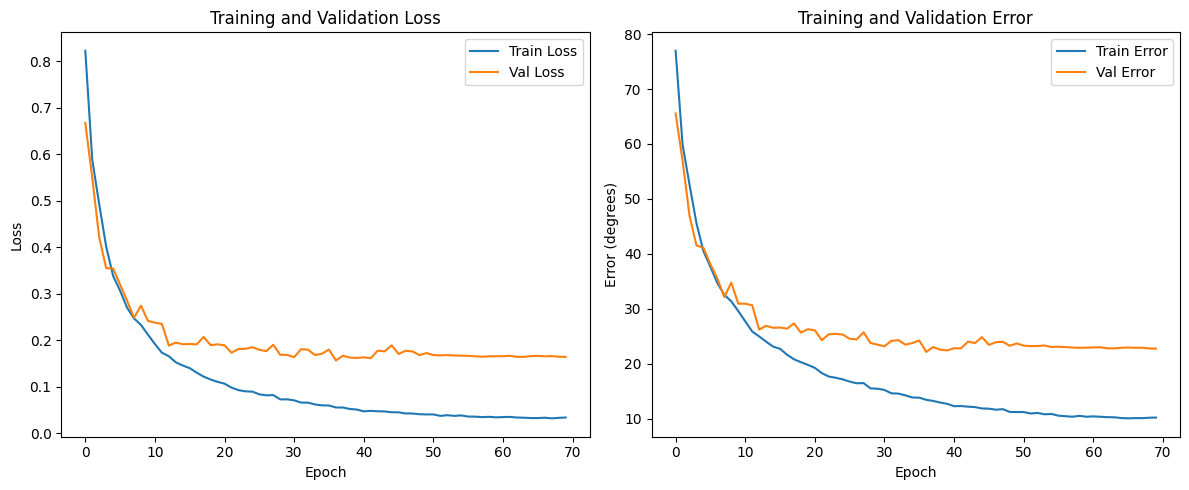

Training completed. Best validation Error: 22.13°


/tmp/ipykernel_19/355825972.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(checkpoint_dir / "best_model.pth")
Validation: 100%|██████████

Final Evaluation - Val Loss: 0.1561, Val Error: 22.13°


Testing: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]



Test Results:
Mean Angular Difference: 22.66°
Median Angular Difference: 11.22°
Standard Deviation: 30.30°


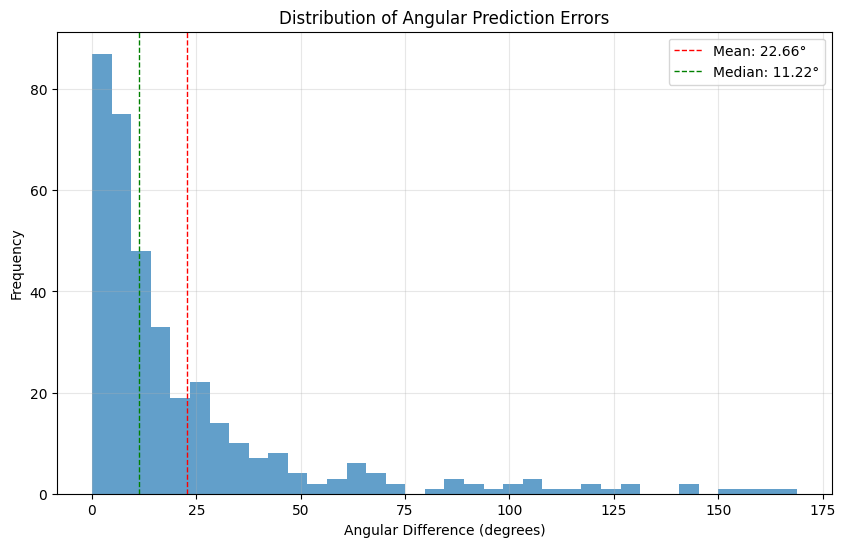

(22.664829185371957,
 11.220059780367585,
 30.303021969398205,
 [305.66682186959986,
  89.28096116979424,
  160.2316480413769,
  308.7348813730671,
  318.07121038353006,
  337.52352596047655,
  317.12407829660816,
  326.87986288438,
  29.80302500935206,
  310.903121509993,
  274.0099400855338,
  230.54484284924206,
  91.49485087603799,
  111.72975074506432,
  285.7510899102991,
  237.72148653471453,
  24.869599862419356,
  85.70075359179198,
  336.4808122063095,
  123.83955320009187,
  313.268658491284,
  10.835657132344702,
  258.955492815152,
  159.44914058892522,
  287.86120172229363,
  101.10076062285222,
  264.7766581390788,
  342.2178996091007,
  286.37622980427363,
  95.33707134079111,
  14.203558525280874,
  285.0812395980176,
  111.88991185091196,
  6.291325664312827,
  226.44735772463807,
  316.17917626645027,
  302.11700863340417,
  31.727270298557656,
  154.042157936268,
  88.72891796031713,
  288.6016693604039,
  262.96300385781944,
  75.63870332163678,
  69.25060497584228

In [4]:
# Run training pipeline
model, _, val_loader, device, checkpoint_dir = run_training_pipeline()
    
# Evaluate model
evaluator = ModelEvaluator(model, val_loader, device, checkpoint_dir)
evaluator.evaluate()

In [5]:
import torch
import os
import pandas as pd
import numpy as np
import math
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

def generate_submission(
    model_path, 
    val_csv_path, 
    val_img_dir, 
    test_img_dir=None,  # Optional test image directory
    output_path='submission.csv',
    batch_size=32,
    rollno='YourRollNo',
    version='1'
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Format output path with roll number and version if not already formatted
    if not output_path.startswith(rollno):
        output_path = f"{rollno}_{version}.csv"
    
    # Load the best model
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    model = TerrainAngleNet(dropout_rate=0.4).to(device)  # Using default dropout rate
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"Model loaded successfully. Best validation error: {checkpoint.get('best_val_error', 'N/A')}°")
    
    # Define validation transform
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create validation dataset and dataloader
    val_dataset = GeoOrientationDataset(
        csv_file=val_csv_path,
        img_dir=val_img_dir,
        transform=val_transform
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Generate predictions for validation set
    print("Generating predictions for validation set...")
    val_predictions, val_true_angles = predict_angles(model, val_loader, device)
    
    # Calculate Mean Absolute Angular Error for validation set
    val_maae = calculate_maae(val_predictions, val_true_angles)
    print(f"Validation Mean Absolute Angular Error (MAAE): {val_maae:.2f}°")
    
    # Create submission dataframe for validation set
    val_df = pd.DataFrame({
        'id': range(len(val_predictions)),
        'angle': val_predictions
    })
    
    # Use test directory if provided
    test_predictions = []
    if test_img_dir:
        print(f"Generating predictions for test images in {test_img_dir}...")
        # Create image-only dataset from test directory
        test_dataset = ImageFolderDataset(
            image_dir=test_img_dir,
            transform=val_transform
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        # Generate predictions for test set
        test_predictions, _ = predict_angles(model, test_loader, device, is_test=True)
        print(f"Generated {len(test_predictions)} predictions for test images")
    else:
        print("No test directory provided. Creating dummy test predictions...")
        # Calculate the number of test samples needed
        total_required = 738  # Total required samples
        num_val_samples = len(val_predictions)
        num_test_samples = total_required - num_val_samples
        
        print(f"Creating {num_test_samples} dummy test predictions to meet requirement of 738 total samples")
        # Generate random angles for test set - replace this with actual logic if needed
        test_predictions = np.random.uniform(0, 360, num_test_samples).tolist()
    
    # Create final submission dataframe
    # Combine validation and test predictions with IDs as specified in the requirements
    test_df = pd.DataFrame({
        'id': range(len(val_predictions), len(val_predictions) + len(test_predictions)),
        'angle': test_predictions
    })
    
    # Concatenate validation and test dataframes
    submission_df = pd.concat([val_df, test_df], ignore_index=True)
    
    # Ensure angles are between 0 and 360 degrees
    submission_df['angle'] = submission_df['angle'].apply(lambda x: x % 360)
    
    # Ensure we have exactly 738 samples
    if len(submission_df) != 738:
        print(f"Warning: Submission has {len(submission_df)} samples, but 738 are required.")
        if len(submission_df) < 738:
            # Add missing samples with random angles
            missing = 738 - len(submission_df)
            print(f"Adding {missing} random predictions to meet the requirement.")
            missing_df = pd.DataFrame({
                'id': range(len(submission_df), 738),
                'angle': np.random.uniform(0, 360, missing).tolist()
            })
            submission_df = pd.concat([submission_df, missing_df], ignore_index=True)
        else:
            # Truncate to 738 samples
            print(f"Truncating to 738 samples.")
            submission_df = submission_df.iloc[:738]
    
    # Save submission CSV
    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")
    print(f"Total rows in submission: {len(submission_df) + 1} (1 header + {len(submission_df)} samples)")
    
    return submission_df, val_maae

def predict_angles(model, dataloader, device, is_test=False):

    model.eval()
    predicted_angles = []
    true_angles = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            if is_test:
                images = batch.to(device)
            else:
                images, angle_vectors, angle_degrees = batch
                images = images.to(device)
                true_angles.extend(angle_degrees.numpy())
            
            # Forward pass
            outputs = model(images)
            
            # Convert output vectors to angles in degrees
            for output in outputs:
                angle_rad = torch.atan2(output[1], output[0])
                angle_deg = angle_rad.item() * 180 / math.pi
                # Normalize to 0-360 range
                if angle_deg < 0:
                    angle_deg += 360
                predicted_angles.append(angle_deg)
    
    return predicted_angles, true_angles

def calculate_maae(predicted_angles, true_angles):

    angular_diffs = []
    for pred, true in zip(predicted_angles, true_angles):
        # Calculate shortest angular distance
        diff = abs(pred - true)
        if diff > 180:
            diff = 360 - diff
        angular_diffs.append(diff)
    
    return np.mean(angular_diffs)

# Image-only dataset class for test images without a CSV file
class ImageFolderDataset(Dataset):
    def __init__(self, image_dir, transform=None):

        self.image_dir = image_dir
        self.transform = transform
        
        # Get all image files in the directory
        self.image_files = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
        
        for file in os.listdir(image_dir):
            if any(file.endswith(ext) for ext in valid_extensions):
                self.image_files.append(file)
        
        # Sort files to ensure consistent ordering
        self.image_files.sort()
        print(self.image_files)
        print(f"Found {len(self.image_files)} image files in {image_dir}")
        
    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [6]:


model_path = "/kaggle/working/best_model.pth"
val_csv_path = "/kaggle/input/labels/labels_val_updated.csv"
val_img_dir = "/kaggle/input/images/images_val/images_val"
test_csv_path = "/path/to/labels_test.csv"  # If available
test_img_dir = "/kaggle/input/images-test/images_test"  # If available
output_path = "2022101113_1.csv"  # Replace with your roll number
    

submission, val_maae = generate_submission(
        model_path=model_path,
        val_csv_path=val_csv_path,
        val_img_dir=val_img_dir,
        test_img_dir=test_img_dir,
        rollno="2022101113",  # Replace with your roll number
        version="2"  # Version of submission
    )
    
print(f"Final MAAE on validation set: {val_maae:.2f}°")

Using device: cuda
Loading model from /kaggle/working/best_model.pth


/tmp/ipykernel_19/2035388003.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Using cache found in /root/.cache/

Model loaded successfully. Best validation error: 22.12710150082906°
Removed 0 outliers from the dataset.
Generating predictions for validation set...


100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Validation Mean Absolute Angular Error (MAAE): 22.66°
Generating predictions for test images in /kaggle/input/images-test/images_test...
['img_0000.jpg', 'img_0001.jpg', 'img_0002.jpg', 'img_0003.jpg', 'img_0004.jpg', 'img_0005.jpg', 'img_0006.jpeg', 'img_0007.jpeg', 'img_0008.jpeg', 'img_0009.png', 'img_0010.png', 'img_0011.png', 'img_0012.jpeg', 'img_0013.jpeg', 'img_0014.jpeg', 'img_0015.jpg', 'img_0016.jpg', 'img_0017.jpg', 'img_0018.jpeg', 'img_0019.jpeg', 'img_0020.jpeg', 'img_0021.jpg', 'img_0022.jpg', 'img_0023.jpg', 'img_0024.jpeg', 'img_0025.jpeg', 'img_0026.jpeg', 'img_0027.jpg', 'img_0028.jpg', 'img_0029.jpg', 'img_0030.jpg', 'img_0031.jpg', 'img_0032.jpg', 'img_0033.jpg', 'img_0034.jpg', 'img_0035.jpg', 'img_0036.jpg', 'img_0037.jpg', 'img_0038.jpg', 'img_0039.jpeg', 'img_0040.jpeg', 'img_0041.jpeg', 'img_0042.jpg', 'img_0043.jpg', 'img_0044.jpg', 'img_0045.jpeg', 'img_0046.jpeg', 'img_0047.jpeg', 'img_0048.jpg', 'img_0049.jpg', 'img_0050.jpg', 'img_0051.jpeg', 'img_0052.j

100%|██████████| 12/12 [00:05<00:00,  2.00it/s]

Generated 369 predictions for test images
Submission saved to 2022101113_2.csv
Total rows in submission: 739 (1 header + 738 samples)
Final MAAE on validation set: 22.66°
